CATE estimators using IPW and DR pseudo-outcomes

Simulated outcome: $ Y = \frac{1}{d}\sum_{i=1}^{d}X_{i} + \epsilon, \text{where}\ \epsilon \sim N(0,0.5)$

Simulated treatment assignment: $ logit(pt) = \alpha\sum_{i=1}^{d}X_{i}$

Covariates: $X \sim N(0,I), \text{where}\ I$ is the identity matrix

In this simulation we vary $\alpha \in \{0,0.2,0.4,0.6\} $ and plot the RMSE of CATE w.r.t. $\alpha$

In [1]:
import numpy as np
from src.synthetic_data import ex2_sample
from src.cate_learners import PseudoDRLearner,PseudoIPWLearner
from src.plots import create_boxplot
import numpy as np
import matplotlib.pyplot as plt

'''
Simulation setup
'''
seed = 2 # for reproducibility
r = 100 # number of simulations
d = 5 # number of covariates
k = 2 # number of folds for cross-fitting 
alpha = np.arange(0,0.8,0.2)
sample_size = 5000 # sample size used for training
num_test = 1000 # sample size used for testing
np.random.seed(seed)

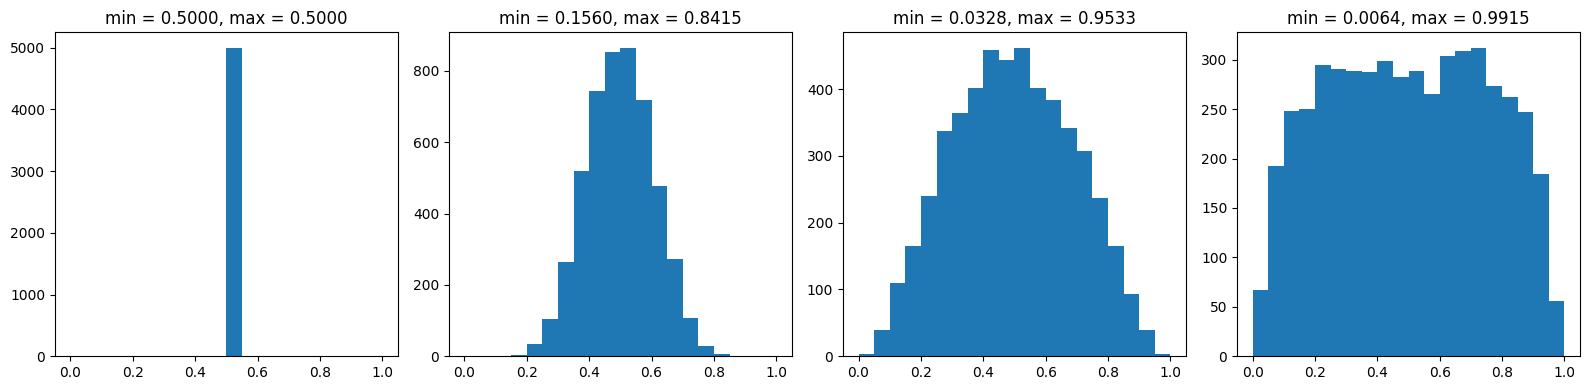

In [2]:
'''
Generate one dataset per value of the coefficient and plot p(T=1|x)
'''
all_pt_values = []
for i in range(len(alpha)):
    dataset = ex2_sample(sample_size,d,alpha[i])
    all_pt_values.append(dataset['pt'])

bins = np.arange(0,1.05,0.05)
fig,ax = plt.subplots(ncols=len(alpha),figsize=(4*len(alpha),4))
for i in range(len(alpha)):
    ax[i].hist(all_pt_values[i],bins=bins)
    ax[i].set_title(f"min = {np.min(all_pt_values[i]):.4f}, max = {np.max(all_pt_values[i]):.4f}")
fig.tight_layout()


In [3]:
'''
Run simulation
'''
dr_cate = []
dr_cate_clip = []
ipw_cate = []
ipw_cate_clip = []
true_ite = []
min_pt_value = np.inf
max_pt_value = -np.inf
for i in range(len(alpha)):
    print(f"Running simulation using strength = {alpha[i]:.2f}...")
    dr_cate_i = np.zeros([r,num_test])
    dr_cate_clip_i = np.zeros([r,num_test])
    ipw_cate_i = np.zeros([r,num_test])
    ipw_cate_clip_i = np.zeros([r,num_test])
    ite_i = np.zeros([r,num_test])
    for j in range(r):
        data_train = ex2_sample(sample_size,d,alpha[i])
        data_test = ex2_sample(num_test,d,alpha[i])
        pt_train = data_train['pt']
        if np.min(pt_train)<min_pt_value:
            min_pt_value = np.min(pt_train)
        if np.max(pt_train)>max_pt_value:
            max_pt_value = np.max(pt_train)

        dr_model = PseudoDRLearner(k,seed)
        dr_model.train(data_train['x'],data_train['y'],data_train['t'])
        dr_cate_i[j,:] = dr_model.predict(data_test['x'])
        ite_i[j,:] = data_test['ite']

        dr_model = PseudoDRLearner(k,seed,0.05)
        dr_model.train(data_train['x'],data_train['y'],data_train['t'])
        dr_cate_clip_i[j,:] = dr_model.predict(data_test['x'])

        ipw_model = PseudoIPWLearner(k,seed)
        ipw_model.train(data_train['x'],data_train['y'],data_train['t'])
        ipw_cate_i[j,:] = ipw_model.predict(data_test['x'])

        ipw_model = PseudoIPWLearner(k,seed,0.05)
        ipw_model.train(data_train['x'],data_train['y'],data_train['t'])
        ipw_cate_clip_i[j,:] = ipw_model.predict(data_test['x'])

    dr_cate.append(dr_cate_i)
    dr_cate_clip.append(dr_cate_clip_i)
    ipw_cate.append(ipw_cate_i)
    true_ite.append(ite_i)
    ipw_cate_clip.append(ipw_cate_clip_i)

print(f"Minimum value of p(T=1|x)={min_pt_value:.4f}")
print(f"Maximum value of p(T=1|x)={max_pt_value:.4f}")

Running simulation using strength = 0.00...
Running simulation using strength = 0.20...
Running simulation using strength = 0.40...
Running simulation using strength = 0.60...
Minimum value of p(T=1|x)=0.0015
Maximum value of p(T=1|x)=0.9971


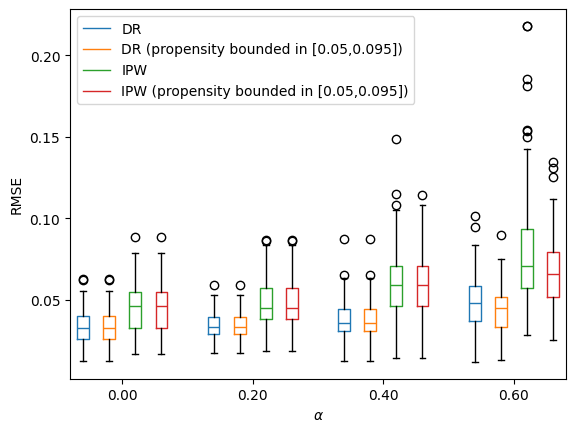

In [4]:
'''
Plot RMSE of CATE
'''
cate_dr = np.zeros([len(alpha),r])
cate_dr_clip = np.zeros([len(alpha),r])
cate_ipw = np.zeros([len(alpha),r])
cate_ipw_clip = np.zeros([len(alpha),r])
cate_outcome = np.zeros([len(alpha),r])
for i in range(len(alpha)):
    cate_dr[i,:] = np.sqrt(np.mean(np.square(dr_cate[i]-true_ite[i]),1))
    cate_dr_clip[i,:] = np.sqrt(np.mean(np.square(dr_cate_clip[i]-true_ite[i]),1))
    cate_ipw[i,:] = np.sqrt(np.mean(np.square(ipw_cate[i]-true_ite[i]),1))
    cate_ipw_clip[i,:] = np.sqrt(np.mean(np.square(ipw_cate_clip[i]-true_ite[i]),1))

CATE_est_names = ["DR","DR (propensity bounded in [0.05,0.095])","IPW","IPW (propensity bounded in [0.05,0.095])"]
CATE_est = [cate_dr,cate_dr_clip,cate_ipw,cate_ipw_clip]
alpha_str = ["{:.2f}".format(a) for a in alpha]
create_boxplot(CATE_est,CATE_est_names,alpha_str,x_lab=r"$\alpha$",y_lab="RMSE",ref=None)
